# Neural networks with Flax

[Flax](https://flax.readthedocs.io/en/latest/) is library for building neural networks with JAX backend. It provides high-level APIs that make it easy to define, train, and deploy neural network models.

In this lecture, we will:

- Generate some simulated data,
- Define a simple feed-forward neural network using Flax.
- Train the model on the simulated data.
- Evaluate the trained model's performance.

In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt

In [2]:
# simulate data
num_samples = 1000
key = jax.random.PRNGKey(42)
X = jax.random.normal(key, shape=(num_samples, 10))
w = jnp.ones((10,))
b = 5.0
noise = jax.random.normal(key, shape=(num_samples,))
y = jnp.dot(X, w) + b + noise

# split into training and test sets
train_X = X[:800]
train_y = y[:800]
test_X = X[800:]
test_y = y[800:]


## Defining the Model with `nn.Module`

Let's define a simple Multi-Layer Perceptron (MLP) model with two hidden layers:




In [3]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        
        # first hidden layer
        x = nn.Dense(features=64)(x)
        x = nn.relu(x)
        
        # second hidden layer
        x = nn.Dense(features=32)(x)
        x = nn.relu(x)
        
        # output layer
        x = nn.Dense(features=1)(x)
        return x

## Create training state

To manage the training process, we need to initialize our model parameters and an optimizer state. We can do this by creating a `TrainState` object from Flax.

In [4]:
def init_model(key, input_shape):
    model = MLP()
    variables = model.init(key, jnp.ones(input_shape))
    tx = optax.adam(learning_rate=0.001)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=variables['params'],
        tx=tx
    )

input_shape = (1,) + train_X.shape[1:]
rng_key = jax.random.PRNGKey(12345)
state = init_model(rng_key, input_shape)

## Define loss function and update function

Now, we define the loss function and update function for training the model.

In [5]:
def compute_loss(params, batch):
    inputs, targets = batch
    preds = state.apply_fn({'params': params}, inputs)
    loss = jnp.mean((preds - targets)**2)
    return loss

@jax.jit
def train_step(state, batch):
    grads = jax.grad(compute_loss)(state.params, batch)
    return state.apply_gradients(grads=grads)

## Training loop

Finally, we write the main training loop where we iterate over batches of data and update the model’s parameters.

Epoch 0: Training Loss = 19.4848 | Test Loss = 22.6702
Epoch 10: Training Loss = 12.5443 | Test Loss = 13.6274
Epoch 20: Training Loss = 12.3206 | Test Loss = 13.2128
Epoch 30: Training Loss = 12.1208 | Test Loss = 13.1249
Epoch 40: Training Loss = 12.0003 | Test Loss = 13.0109
Epoch 50: Training Loss = 11.9139 | Test Loss = 12.8543
Epoch 60: Training Loss = 11.8530 | Test Loss = 12.7370
Epoch 70: Training Loss = 11.8231 | Test Loss = 12.6643
Epoch 80: Training Loss = 11.7928 | Test Loss = 12.5550
Epoch 90: Training Loss = 11.8982 | Test Loss = 12.4881


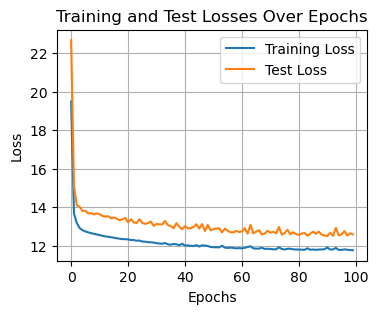

In [6]:
batch_size = 32
num_epochs = 100

training_losses = []
test_losses = []

for epoch in range(num_epochs):
    perm = jax.random.permutation(jax.random.PRNGKey(epoch), len(train_X))
    train_X_perm = train_X[perm]
    train_y_perm = train_y[perm]
    
    for i in range(0, len(train_X), batch_size):
        batch_X = train_X_perm[i:i+batch_size]
        batch_y = train_y_perm[i:i+batch_size]
        state = train_step(state, (batch_X, batch_y))
    
    # Compute training loss
    train_loss = compute_loss(state.params, (train_X, train_y))
    training_losses.append(train_loss)
    
    # Compute test loss
    test_loss = compute_loss(state.params, (test_X, test_y))
    test_losses.append(test_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Training Loss = {train_loss:.4f} | Test Loss = {test_loss:.4f}")

# plotting the training and test losses
plt.figure(figsize=(4, 3))
plt.plot(training_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()